In [1]:
# load libs and modules
import numpy as np
import pandas as pd
import get_data
import preprocess_data

from sqlalchemy import create_engine
from MyCreds.mycreds import Capstone_AWS_RO       #from local site-packages

# for VIF
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# get data with location features - shorter time frame (15 years - 441k data points)
train_df_dl,validate_df_dl,test_df_dl = get_data.get_data('resale_location_features',2007,2015,2016,2018,2019)

Getting Training Data
Training Data Done
Getting Validate Data
Validate Data Done
Getting Test Data
Test Data Done


In [3]:
one_hot_encode = ['town','flat_model']

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

In [7]:
# create train_test_splits

columns_to_drop = ['resale_price_norm',
                'price_per_sq_ft_norm',
                'price_per_sq_m_norm',
                'price_per_sq_ft_per_lease_yr_norm',
                'price_per_sq_m_per_lease_yr_norm',
                ]
targets = ['price_per_sq_m_per_lease_yr_norm']
features_list = [x for x in train_df.columns.tolist() if x not in columns_to_drop]

X_train = train_df[features_list]
y_train = train_df[targets]
X_test = test_df[features_list]
y_test = test_df[targets]
X_val = validate_df[features_list]
y_val = validate_df[targets]

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Standardize features
X_train_scaled = scale(X_train)
X_val_scaled = scale(X_val)
X_test_scaled = scale(X_test)

In [14]:
# Define cross-validation folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Linear Regression
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='r2').mean()
lr_score_val = r2_score(y_val, lin_reg.predict(X_val_scaled))
lr_score_test = r2_score(y_test, lin_reg.predict(X_test_scaled))

print(lr_score_train)
print(lr_score_val)
print(lr_score_test)

# # Lasso Regression
# lasso_reg = LassoCV().fit(X_train_scaled, y_train)
# lasso_score_train = -1 * cross_val_score(lasso_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
# lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test_scaled), squared=False)

# # Ridge Regression
# ridge_reg = RidgeCV().fit(X_train_scaled, y_train)
# ridge_score_train = -1 * cross_val_score(ridge_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
# ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test_scaled), squared=False)

0.9003014003145247
0.8082040061945083
0.6949270833229249


In [37]:
# test on small set of PC
pca = PCA(n_components = 10)
X_train_pc = pca.fit_transform(X_train_scaled)

In [38]:
pd.DataFrame(pca.components_,columns= X_train.columns).T

,0,1,2,3,4,5,6,7,8,9
storey_range_min,0.006593,0.008355,-0.000977,0.078979,-0.026257,0.069500,0.167184,-0.030640,0.106718,0.045662
storey_range_max,0.006576,0.008401,-0.001012,0.078953,-0.026282,0.069429,0.166980,-0.030566,0.106534,0.045689
n_rooms,-0.023599,-0.010392,-0.030846,0.107975,-0.155315,0.038821,0.228539,0.058389,0.235691,-0.071298
floor_area_sqm,-0.023961,-0.009637,-0.017537,0.075407,-0.163112,0.022489,0.215575,0.086737,0.263256,-0.045203
remaining_lease_years,-0.031701,-0.005149,-0.063650,0.148066,-0.124934,0.061025,0.177710,0.007063,0.072630,-0.052771
...,...,...,...,...,...,...,...,...,...,...
flat_model_simplified,-0.000191,-0.006821,-0.032309,-0.056465,0.032386,-0.011637,-0.052195,0.017519,-0.073118,-0.131989
flat_model_standard,0.018020,0.006704,0.033005,-0.007772,0.031086,0.036451,-0.051323,-0.035930,0.008125,-0.058943
flat_model_terrace,0.003226,0.000738,-0.001522,-0.003846,-0.004322,-0.001944,-0.001605,0.030799,-0.011937,-0.047076
flat_model_type_s1,0.002845,0.001544,0.009924,0.020562,0.030067,0.042992,0.048569,-0.004500,0.022599,0.053147


In [39]:
pca.explained_variance_ratio_

array([0.58067917, 0.1495504 , 0.03538806, 0.01939942, 0.01253077,
       0.0123686 , 0.00822713, 0.00728857, 0.0066328 , 0.0065567 ])

In [41]:
# Generate all the principal components
pca = PCA() # Default n_components = min(n_samples, n_features)
X_train_pc = pca.fit_transform(X_train_scaled)

# View first 5 rows of all principal components
pd.DataFrame(pca.components_.T).loc[:4,:]

,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,360,361,362
0,0.006593,0.008355,-0.000977,0.078979,-0.026256,0.069493,0.167340,-0.030924,0.107401,0.046214,...,1.003693e-07,-6.337172e-08,4.462188e-08,-4.046865e-08,-1.330088e-07,-4.023660e-08,3.971583e-08,5.882166e-16,0.000000e+00,0.000000e+00
1,0.006576,0.008401,-0.001012,0.078953,-0.026281,0.069422,0.167136,-0.030849,0.107217,0.046238,...,-9.087149e-08,1.149242e-07,-5.135279e-08,3.055371e-08,1.362826e-07,1.506293e-08,-4.092599e-08,-5.731475e-16,6.255336e-19,2.412474e-20
2,-0.023599,-0.010392,-0.030846,0.107975,-0.155315,0.038808,0.228822,0.058341,0.237516,-0.070159,...,4.091761e-07,-1.420061e-07,-2.853875e-07,1.836651e-08,-1.661073e-07,1.308459e-07,4.218987e-08,9.755098e-17,2.792026e-18,2.646025e-19
3,-0.023961,-0.009637,-0.017537,0.075407,-0.163110,0.022481,0.215868,0.086573,0.264412,-0.043849,...,-3.021875e-07,-3.804434e-09,3.343880e-07,-1.748324e-07,2.493762e-07,-3.705981e-08,-4.702376e-09,-9.718482e-17,-1.008744e-18,-2.944738e-20
4,-0.031701,-0.005149,-0.063650,0.148065,-0.124927,0.061025,0.177857,0.006196,0.072808,-0.050611,...,8.927942e-11,1.726816e-07,-7.684651e-08,-1.560850e-07,8.894982e-08,-4.966775e-08,-4.662373e-08,7.214361e-17,-5.338130e-19,-2.000324e-20


In [42]:
pca.explained_variance_ratio_

array([5.80679174e-01, 1.49550396e-01, 3.53880621e-02, 1.93994197e-02,
       1.25307695e-02, 1.23686035e-02, 8.22717620e-03, 7.28871004e-03,
       6.63363390e-03, 6.55768307e-03, 6.07779463e-03, 5.73826846e-03,
       5.32466461e-03, 5.00009162e-03, 4.81164463e-03, 4.65333494e-03,
       4.43336127e-03, 4.11593338e-03, 4.03340507e-03, 3.91933018e-03,
       3.84496657e-03, 3.62045301e-03, 3.54073413e-03, 3.31878058e-03,
       3.26554903e-03, 3.20421714e-03, 3.14095907e-03, 3.05641495e-03,
       3.05222364e-03, 3.01449135e-03, 2.91600387e-03, 2.84904097e-03,
       2.81317136e-03, 2.78191267e-03, 2.76945907e-03, 2.76294493e-03,
       2.76271077e-03, 2.76019428e-03, 2.75238353e-03, 2.72828373e-03,
       2.69226765e-03, 2.66158600e-03, 2.64000883e-03, 2.51339824e-03,
       2.44089457e-03, 2.43546015e-03, 2.31474702e-03, 2.18091766e-03,
       2.09342578e-03, 2.02393816e-03, 1.93153705e-03, 1.88886573e-03,
       1.71822884e-03, 1.58899546e-03, 1.48238875e-03, 1.37286033e-03,
      

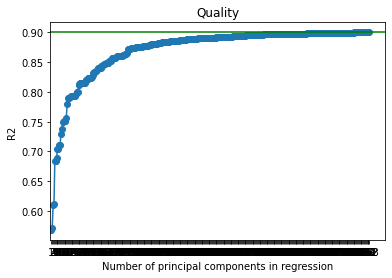

In [43]:
import matplotlib.pyplot as plt

# Initialize linear regression instance
lin_reg = LinearRegression()

# Create empty list to store R2 for each iteration
r2_list = []

# Loop through different count of principal components for linear regression
for i in range(1, X_train_pc.shape[1]+1):
    r2_scores = cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='r2').mean()
    r2_list.append(r2_scores)
    
# Visual analysis - plot R2 vs count of principal components used
plt.plot(r2_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('R2')
plt.title('Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

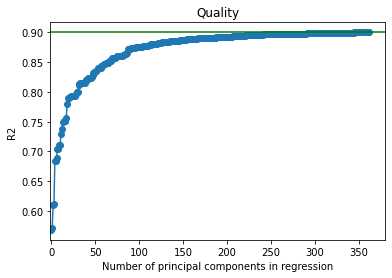

In [44]:
# Visual analysis - plot R2 vs count of principal components used
plt.plot(r2_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('R2')
plt.title('Quality')
plt.xlim(xmin=-1);
# plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');